In [10]:
import pandas as pd
import numpy as np
from datetime import datetime, date 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

In [2]:
path = r'C:\Users\matte\OneDrive\Desktop\GitHub\data\Petrignano\Aquifer_Petrignano.csv'
df = pd.read_csv(path)
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [3]:
# Remove not usefull columns
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [4]:
# Simplify column names
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4199 entries, 0 to 4198
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  4199 non-null   object 
 1   rainfall              4199 non-null   float64
 2   depth_to_groundwater  4172 non-null   float64
 3   temperature           4199 non-null   float64
 4   drainage_volume       4198 non-null   float64
 5   river_hydrometry      4199 non-null   float64
dtypes: float64(5), object(1)
memory usage: 197.0+ KB


## Data cleaning

In [7]:
# Parse object type to datetime type
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


In [8]:
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

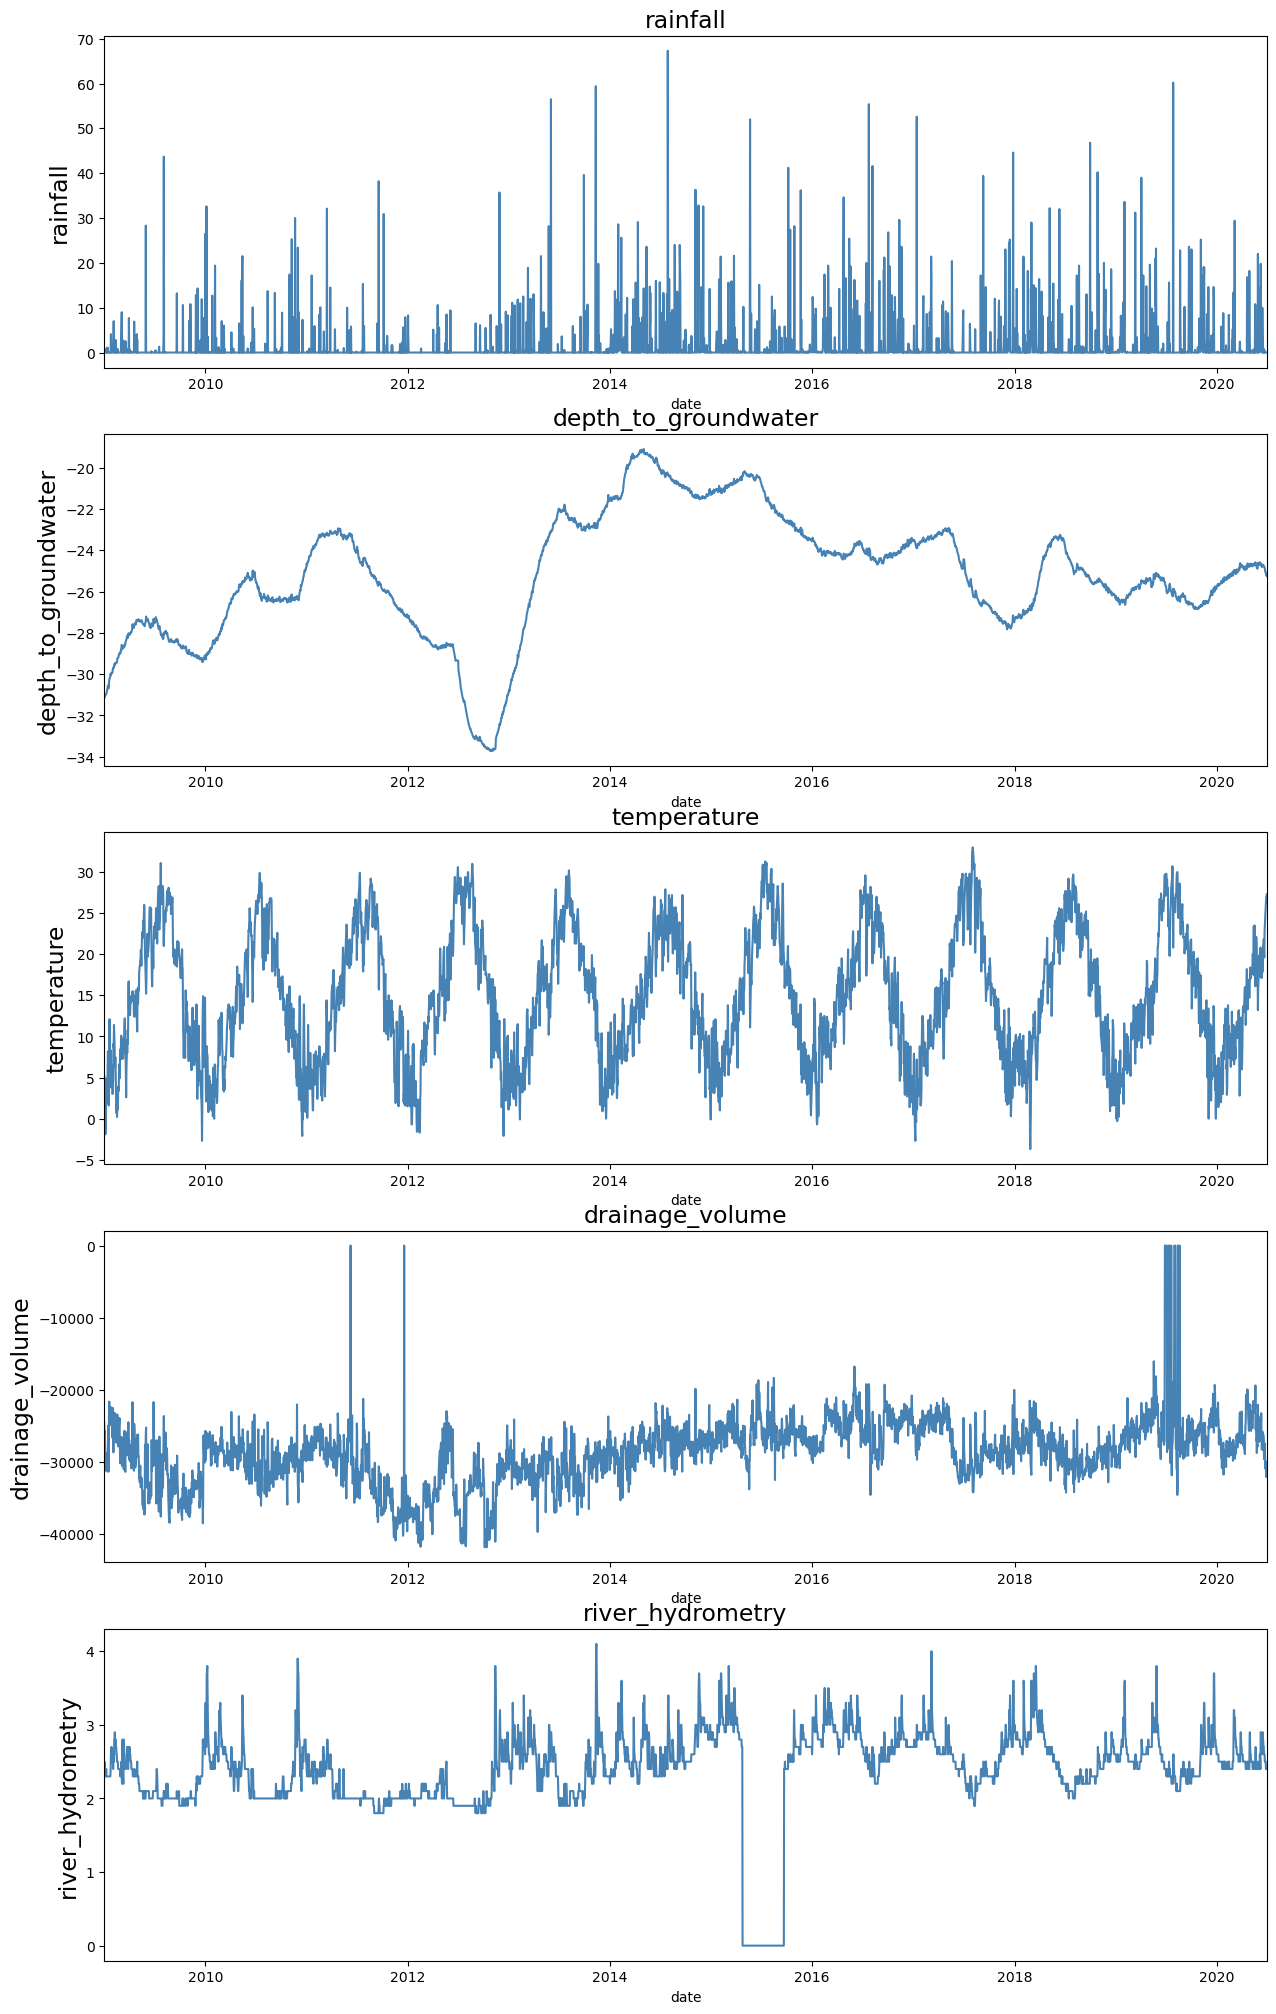

In [12]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    # For now I handle missing value with fillna
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='steelblue')
    ax[i].set_title(column, fontsize=17)
    ax[i].set_ylabel(column, fontsize=17)
                      
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])     

I see no reasons why the river_hydrometry would be 0 just before 2016. This is likely a bias in the data, so I'll convert values == 0 to np.nan.

In [13]:
df['river_hydrometry_back_up'] = df['river_hydrometry'].copy()
df.loc[df['river_hydrometry']==0, 'river_hydrometry'] = np.nan

# Fill nan values with interpolate
df['hydro_fill'] = df['river_hydrometry'].interpolate()

# This is for the next visualization
df.loc[df['river_hydrometry'].notna(), 'hydro_fill'] = np.nan

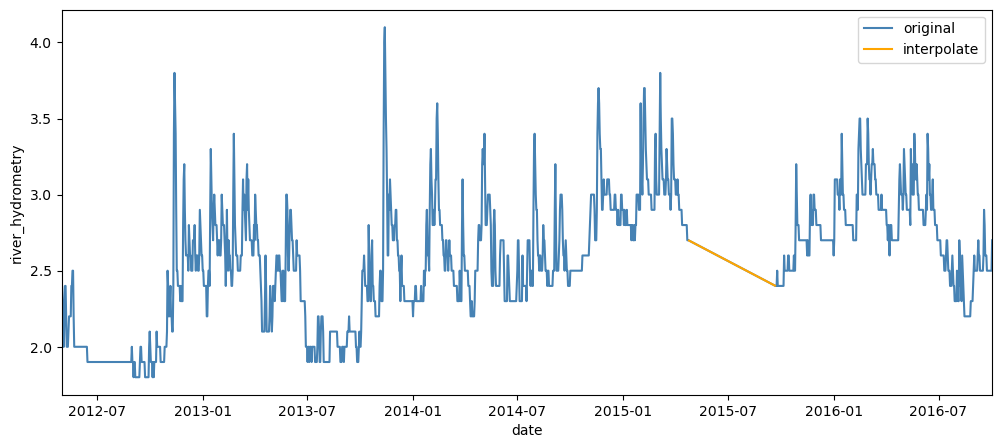

In [21]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.lineplot(x=df['date'], y=df['river_hydrometry'], color='steelblue',
             label='original', ax=ax)
sns.lineplot(x=df['date'], y=df['hydro_fill'], color='orange',
             label='interpolate', ax=ax)
ax.set_xlim([date(2012, 5, 1), date(2016, 10, 1)])
plt.show()

In [25]:
# interpolate in this case is quite good, so I'll use it for each of the columns

df['river_hydrometry'] = df['river_hydrometry_back_up'].interpolate()
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()
df.drop(columns=['hydro_fill', 'river_hydrometry_back_up'], inplace=True)

df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3
